Скачайте материалы к ДЗ. Проанализируйте ряды, сделайте их стационарными.

Решением будет ссылка на гитхаб с ноутбуком.

In [175]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import parser
from datetime import datetime, date, time
from datetime import timedelta
from pandas_datareader import data

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [3]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

### Первый временной ряд

In [88]:
# смотрим на данные
series_1 = pd.read_csv('monthly-us-auto-registration-tho.csv',sep=';', 
                       index_col=['Month'], names = ['Month', 'auto_registration'], header=0, parse_dates=['Month'])
series_1.head()

,auto_registration
Month,
1947-01-01,209
1947-02-01,214
1947-03-01,265
1947-04-01,290
1947-05-01,287


In [89]:
# благодаря параметру parse_dates в колонке 'Month' данные типа Timestamp
type(series_1['auto_registration'].index[0])

pandas._libs.tslibs.timestamps.Timestamp

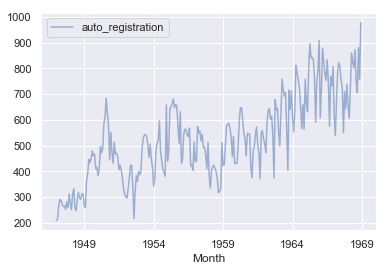

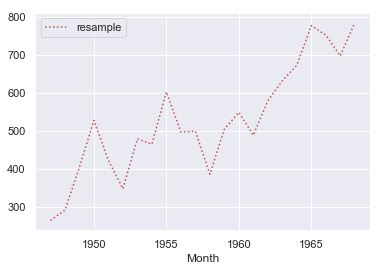

In [90]:
# изобразим график
series_1.plot(alpha=0.5, style='-')
series_1.resample('BA').mean().plot(style=':r') # среднее значение за предыдущий год
plt.legend(['resample'], loc='upper left')

Что видно глазами:

1. Есть ли у ряда тренд - есть.

2. Есть ли у ряда сезонность (аддитивная, мультипликативая)? - скорее нет, чем да.

3. Меняет ли ряд свой характер? - скорее нет, чем да. Отрасывать ранние данные не будем.

4. Имеет ли ряд циклы? - скорее нет, чем да.

5. Имеет ли ряд выбросы? - скорее нет, чем да.

In [91]:
def test_stationarity(timeseries):
    """проводит тест Дикки - Фуллера"""
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC') # The Augmented Dickey-Fuller test 
    # can be used to test for a unit root in a univariate process in the presence of serial correlation
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [92]:
test_stationarity(series_1.iloc[:,0])

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [93]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


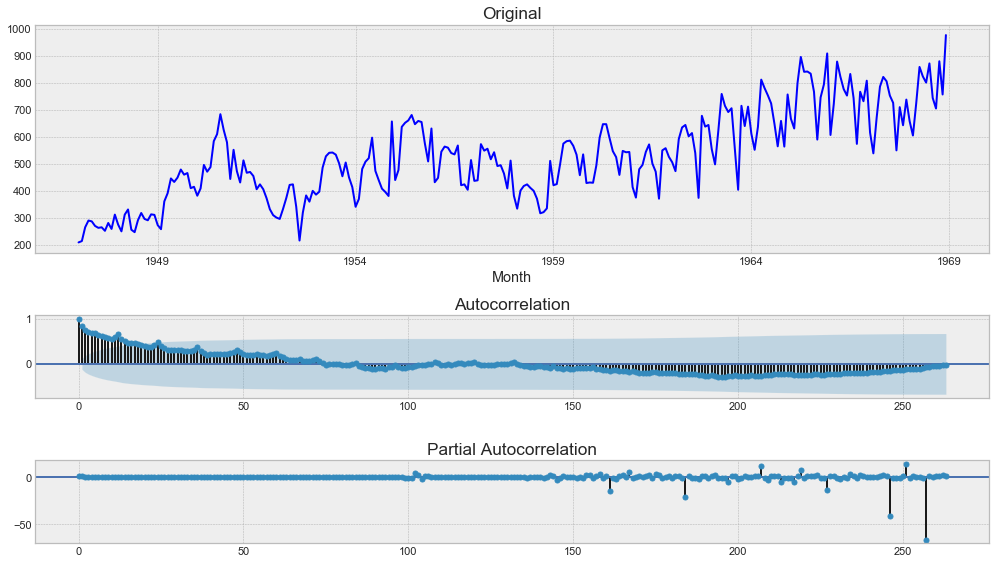

In [94]:
tsplot(series_1.iloc[:,0])

Коэффициент автокорреляции измеряет связь между текущими и прошлыми наблюдениями временного ряда.

Частный коэффициент автокорреляции определяет степень автокорреляции временного ряда.

Как мы видим, и тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда. Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса

In [95]:
# переведем уже series_1 из датафрейма в Series
series_1 = series_1.iloc[:,0]

In [96]:
series_1 = boxcox(series_1, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.941628
p-value                          0.312738
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


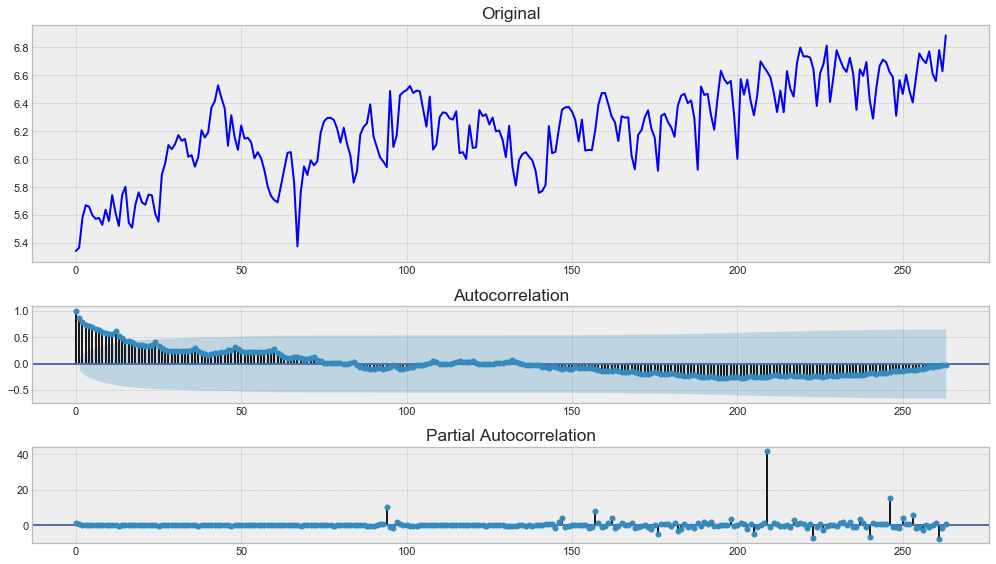

In [98]:
tsplot(series_1)

Нам удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.

In [99]:
series_1 = series_1[1:] - series_1[:-1]

Results of Dickey-Fuller Test:
Test Statistic                  -4.362471
p-value                          0.000346
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


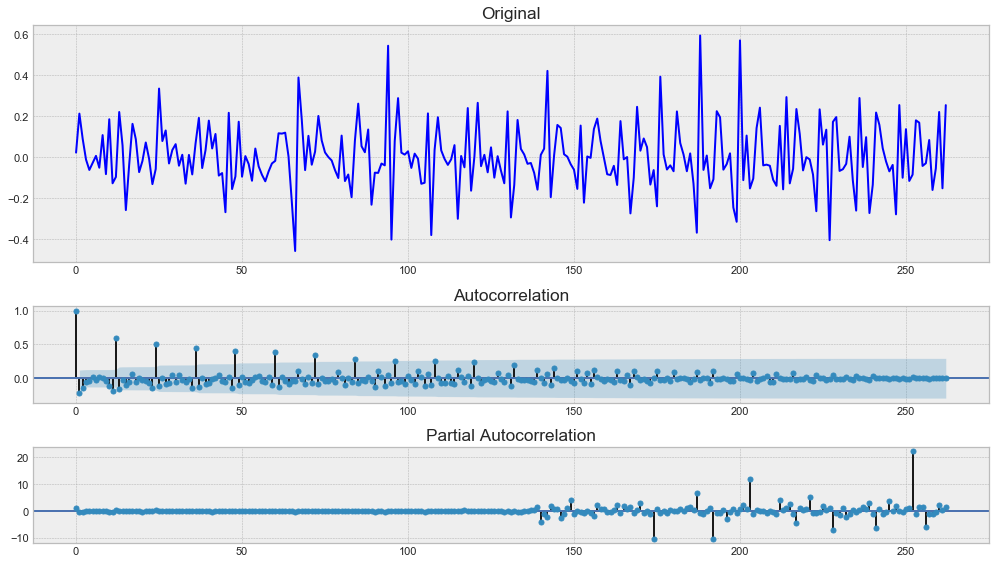

In [100]:
tsplot(series_1)

Стало еще лучше, но по графику коррелограммы видно сильное влияние сезонности. Уберем ее

In [101]:
series_1 = series_1[12:] - series_1[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


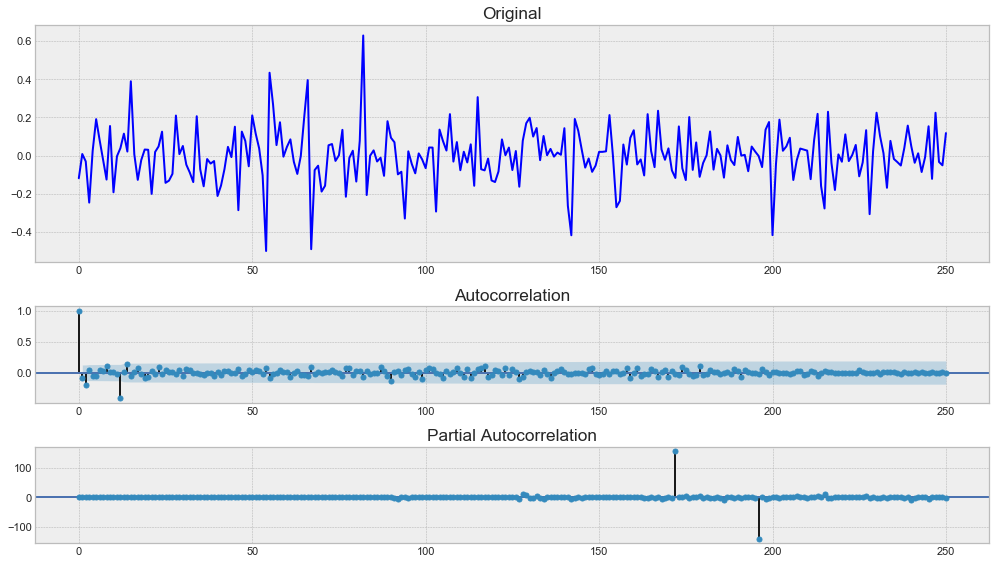

In [102]:
tsplot(series_1)

Можно считать полученный ряд стационарным.

### Второй временной ряд


In [152]:
series_2 = pd.read_csv('weekly-closings-of-the-dowjones-.csv', parse_dates = ['Week'], keep_default_na=False)
series_2.head()

,Week,"Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974"
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [153]:
def parser(list_, delim1='-', delim2='W'):
    """парсер, который преобразует значения последовательности строк 
    вида '1971-W27' в datetime"""
    years_str = list(map(lambda x: str(x.split(delim1)[0]), list_))
    weeks_int = list(map(lambda x: int(x.split(delim2)[1]), list_))
    dates_dt = []
    
    for years, week in zip(years_str, weeks_int):
        d = datetime.strptime(years, "%Y") + timedelta(weeks=week)
        dates_dt.append(d)
        
    return dates_dt

In [154]:
# получили список datetime, смотрим первые 10 значений
l = pd.read_csv('weekly-closings-of-the-dowjones-.csv', parse_dates = ['Week'], keep_default_na=False)['Week']
parser(l)[:10]

[datetime.datetime(1971, 7, 9, 0, 0),
 datetime.datetime(1971, 7, 16, 0, 0),
 datetime.datetime(1971, 7, 23, 0, 0),
 datetime.datetime(1971, 7, 30, 0, 0),
 datetime.datetime(1971, 8, 6, 0, 0),
 datetime.datetime(1971, 8, 13, 0, 0),
 datetime.datetime(1971, 8, 20, 0, 0),
 datetime.datetime(1971, 8, 27, 0, 0),
 datetime.datetime(1971, 9, 3, 0, 0),
 datetime.datetime(1971, 9, 10, 0, 0)]

In [155]:
# выведем их списком понятных значений (%U - номер недели в году)
list(map(lambda x: datetime.strftime(x, "%Y-%m-%d-%U"), parser(l)))[:10]


['1971-07-09-27',
 '1971-07-16-28',
 '1971-07-23-29',
 '1971-07-30-30',
 '1971-08-06-31',
 '1971-08-13-32',
 '1971-08-20-33',
 '1971-08-27-34',
 '1971-09-03-35',
 '1971-09-10-36']

In [156]:
# меняем значения в столбце 'Week'
series_2['Week'] = parser(l)
series_2.head()

,Week,"Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974"
0,1971-07-09,890.19
1,1971-07-16,901.80
2,1971-07-23,888.51
3,1971-07-30,887.78
4,1971-08-06,858.43


In [157]:
# проверяем, что значения нужного типа
type(series_2['Week'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [158]:
# убираем даты в индекс
series_2.index = series_2['Week']
series_2.head()

,Week,"Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974"
Week,,
1971-07-09,1971-07-09,890.19
1971-07-16,1971-07-16,901.80
1971-07-23,1971-07-23,888.51
1971-07-30,1971-07-30,887.78
1971-08-06,1971-08-06,858.43


In [159]:
# избавляемся от ненужного поля 'Week'
del series_2['Week']
series_2.head()

,"Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974"
Week,
1971-07-09,890.19
1971-07-16,901.80
1971-07-23,888.51
1971-07-30,887.78
1971-08-06,858.43


In [160]:
# переименовываем колонку
series_2.columns = ['Weekly_closings']
series_2.head()

,Weekly_closings
Week,
1971-07-09,890.19
1971-07-16,901.80
1971-07-23,888.51
1971-07-30,887.78
1971-08-06,858.43


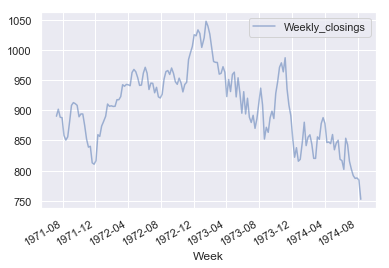

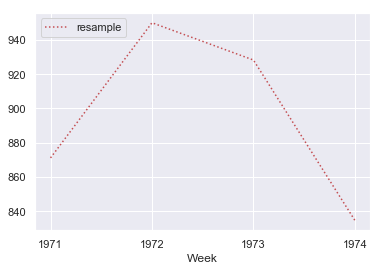

In [161]:
# изобразим график
series_2.plot(alpha=0.5, style='-')
series_2.resample('BA').mean().plot(style=':r') # среднее значение за предыдущий год
plt.legend(['resample'], loc='upper left')

Что видно глазами:

1. Есть ли у ряда тренд - общего тренда нет, каждый год своя история.

2. Есть ли у ряда сезонность (аддитивная, мультипликативая)? - скорее нет, чем да.

3. Меняет ли ряд свой характер? - дисперсия вроде бы увеличивается со временем.

4. Имеет ли ряд циклы? - скорее нет, чем да.

5. Имеет ли ряд выбросы? - есть пара сильных пиков и падений.

In [162]:
series_2 = series_2.iloc[:,0]

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


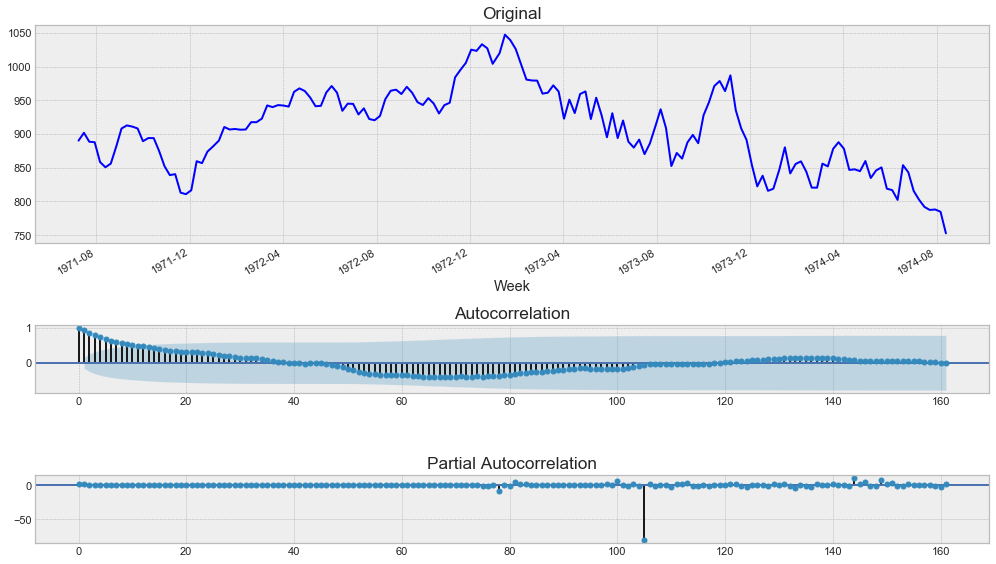

In [163]:
tsplot(series_2)

In [164]:
series_2 = boxcox(series_2, 0.25) # боремся с увеличивающейся дисперсией

Results of Dickey-Fuller Test:
Test Statistic                  -1.237336
p-value                          0.657332
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


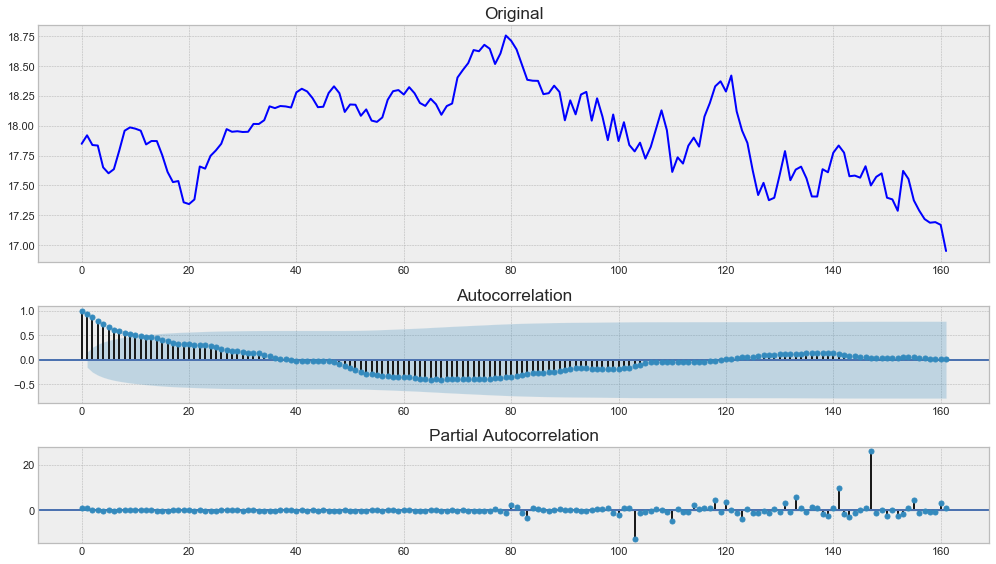

In [165]:
tsplot(series_2)

In [166]:
# как-то не помогло

In [167]:
series_2 = series_2[1:] - series_2[:-1] # с трендом поступаем так: дифференцируем

Results of Dickey-Fuller Test:
Test Statistic                -1.300518e+01
p-value                        2.636917e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


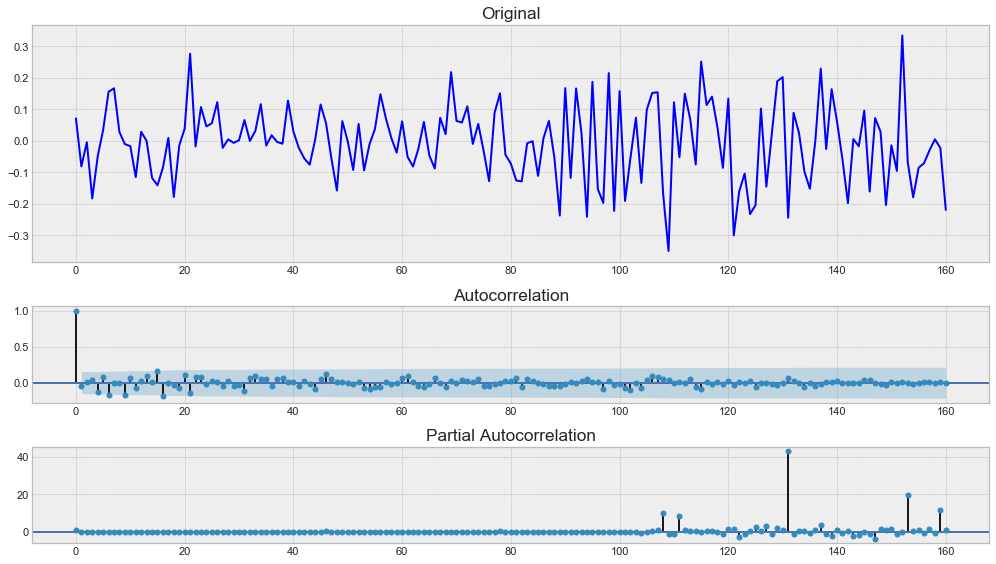

In [168]:
tsplot(series_2)

In [169]:
series_2 = series_2[1:] - series_2[:-1] # еще раз продифференцируем (нормально делать 3-4 раза не больше). Сезонности не видно

Results of Dickey-Fuller Test:
Test Statistic                  -5.085051
p-value                          0.000015
#Lags Used                      14.000000
Number of Observations Used    145.000000
Critical Value (1%)             -3.476273
Critical Value (5%)             -2.881688
Critical Value (10%)            -2.577513
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


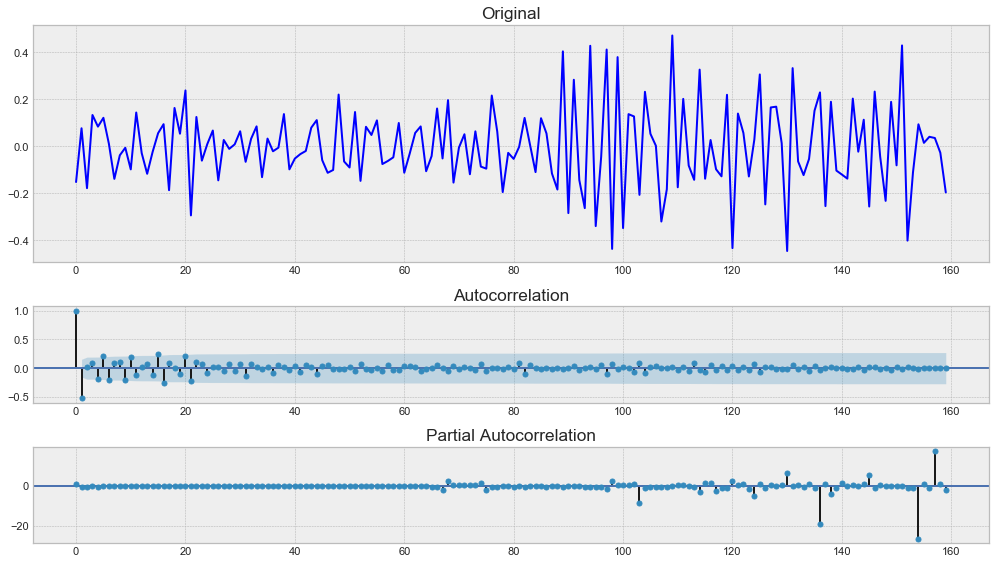

In [170]:
tsplot(series_2)

In [171]:
series_2 = series_2[1:] - series_2[:-1] # попробуем еще раз справиться с дисперсией

Results of Dickey-Fuller Test:
Test Statistic                -7.531140e+00
p-value                        3.575983e-11
#Lags Used                     1.400000e+01
Number of Observations Used    1.440000e+02
Critical Value (1%)           -3.476598e+00
Critical Value (5%)           -2.881829e+00
Critical Value (10%)          -2.577589e+00
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


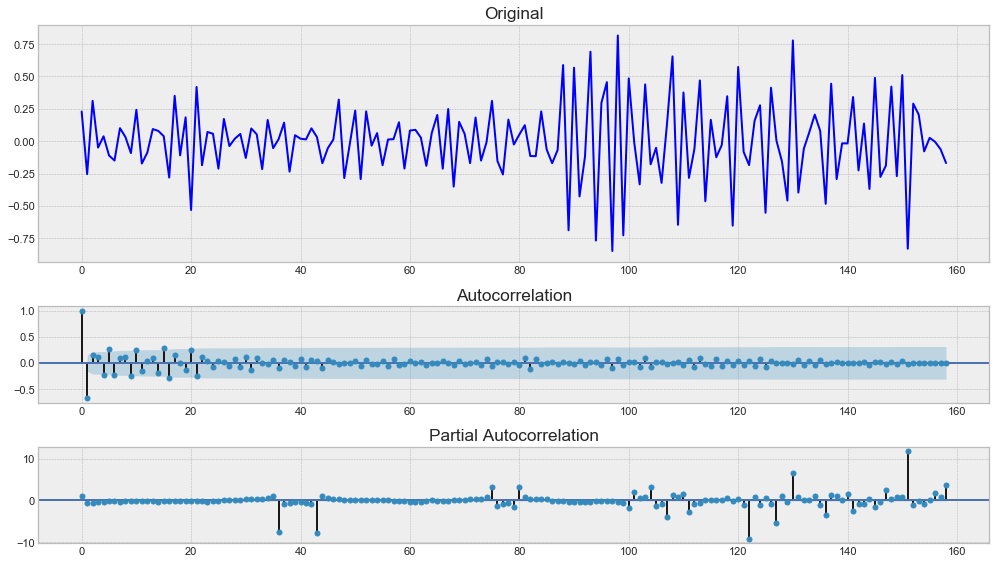

In [172]:
tsplot(series_2)

In [173]:
series_2 = series_2[1:] - series_2[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -7.433969e+00
p-value                        6.253755e-11
#Lags Used                     1.400000e+01
Number of Observations Used    1.430000e+02
Critical Value (1%)           -3.476927e+00
Critical Value (5%)           -2.881973e+00
Critical Value (10%)          -2.577665e+00
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


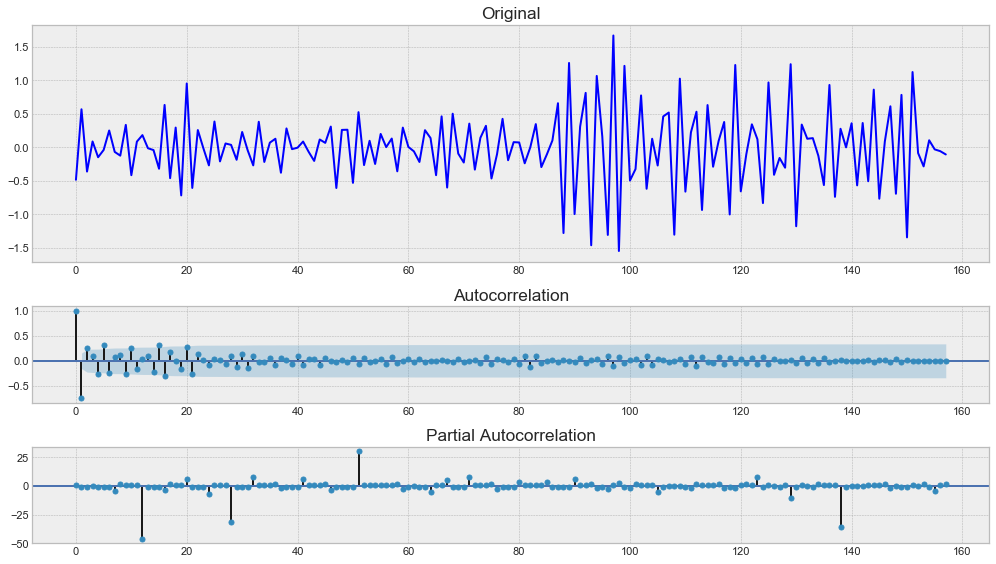

In [174]:
tsplot(series_2)

Ряд стационарен